**Base model + Mask**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
import os

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Data/')

Mounted at /content/drive/


In [ ]:
class Config:

    BASE_PATH = '/content/drive/My Drive/Data/Research/Process_2/'
    IMAGES_PATH = os.path.sep.join([BASE_PATH, "Train"])
    ANNOTS_PATH = os.path.sep.join([BASE_PATH, "hip_coord2.csv"])

    BASE_OUTPUT = '/content/drive/My Drive/Data/Research/Process_2/output/'


    TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])


    INIT_LR = 1e-4
    NUM_EPOCHS = 10
    BATCH_SIZE = 32


config = Config()

In [ ]:

print("[INFO] loading dataset...")
rows = open(config.ANNOTS_PATH).read().strip().split("\n")


data = []
targets = []
filenames = []

[INFO] loading dataset...


In [ ]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:

for row in rows:

	row = row.split(",")
	(filename, startX, startY, endX, endY) = row


	imagePath = os.path.sep.join([config.IMAGES_PATH, filename])
	image = cv2.imread(imagePath)
	(h, w) = (128,128)


	startX = float(startX) / w
	startY = float(startY) / h
	endX = float(endX) / w
	endY = float(endY) / h

	# load the image and preprocess it
	image = load_img(imagePath, target_size=(128, 128))
	image = load_image_into_numpy_array(image)


	data.append(image)
	targets.append((startX, startY, endX, endY))
	filenames.append(filename)

In [ ]:

data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")


split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)


(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]


print("[INFO] saving testing filenames...")
f = open(config.TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


In [ ]:

vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(128, 128, 3)))


vgg.trainable = False


flatten = vgg.output
flatten = Flatten()(flatten)


bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

model = Model(inputs=vgg.input, outputs=bboxHead)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:

opt = Adam(lr=config.INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())

# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=config.BATCH_SIZE,
	epochs=config.NUM_EPOCHS,
	verbose=1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

[INFO] saving object detector model...


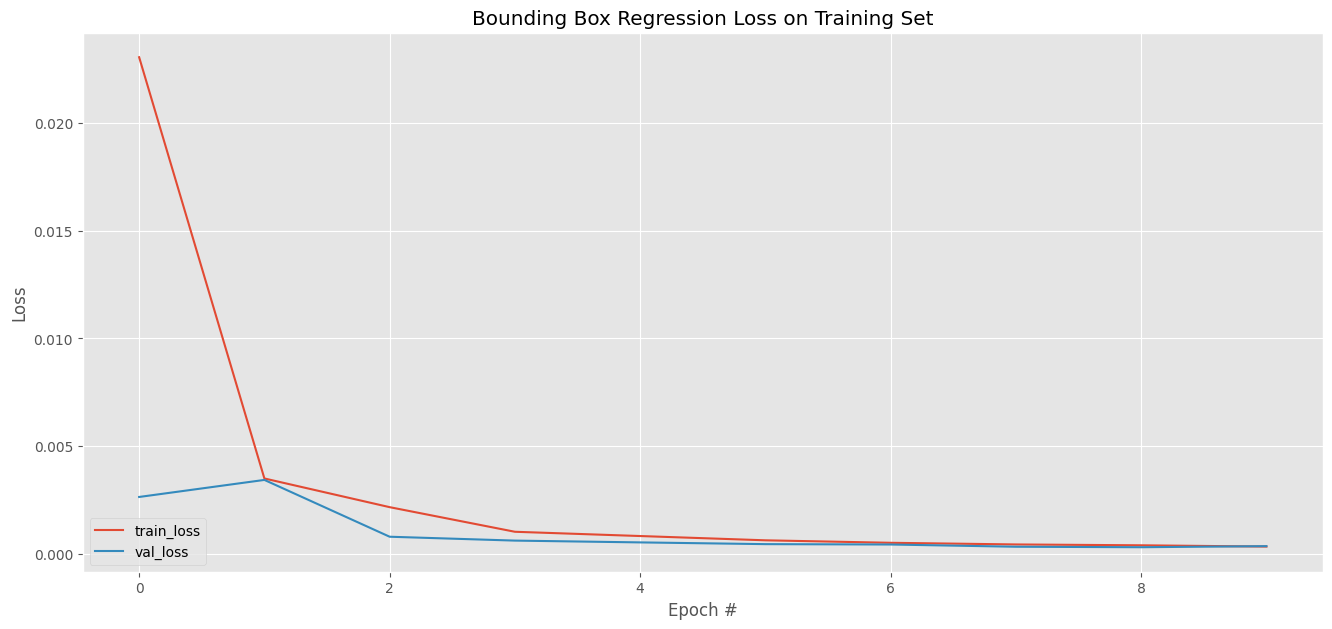

In [ ]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save('detection_mask', save_format="h5")

# plot the model training history
N = config.NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

In [ ]:
model.save('detection_mask.h5')

Apply predition model for bbox on image

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import io
import seaborn as sns

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import EfficientNetB4
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model

import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

In [ ]:
labels = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [ ]:
imagePaths = []
Y_train = [] #Training Labels

for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/Data/Research/Process_1/', 'train', i)
    for j in tqdm(os.listdir(folderPath)):
      p = os.path.sep.join([folderPath, j])
      imagePaths.append(p)
      Y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/Data/Research/Process_1/', 'test', i)
    for j in tqdm(os.listdir(folderPath)):
      p = os.path.sep.join([folderPath, j])
      imagePaths.append(p)
      Y_train.append(i)

Ytrain = np.array(Y_train)

100%|██████████| 224/224 [00:00<00:00, 154501.58it/s]


In [ ]:
Ytrain.shape

(5761,)

In [ ]:
# load our trained bounding box regressor from disk
print("[INFO] loading object detector...")
model = load_model('detection_mask.h5')
X_train = [] #Training Dataset

# loop over the images that we'll be testing using our bounding box
# regression model
for i in imagePaths:
  image = load_img(i, target_size=(128, 128,1))
  image = img_to_array(image) / 255.0
  image = np.expand_dims(image, axis=0)

  preds = model.predict(image)[0]
  (startX, startY, endX, endY) = preds
  image = cv2.imread(i)
  (h, w) = image.shape[:2]

  startX = int(startX * w)
  startY = int(startY * h)
  endX = int(endX * w)
  endY = int(endY * h)

  mask = np.zeros(image.shape[:2], dtype="uint8")
  box_img = cv2.rectangle(mask, (startX-5, startY-5), (endX+5, endY+5),255, -1)
  masked_img = cv2.bitwise_and(image, image, mask=mask)

  X_train.append(masked_img)



Xtrain = np.array(X_train)

Xtrain.shape

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step


(5761, 128, 128, 3)

In [ ]:
Ytrain.shape

(5761,)

In [ ]:
Xtrain.shape

(5761, 128, 128, 3)

ValueError: ignored

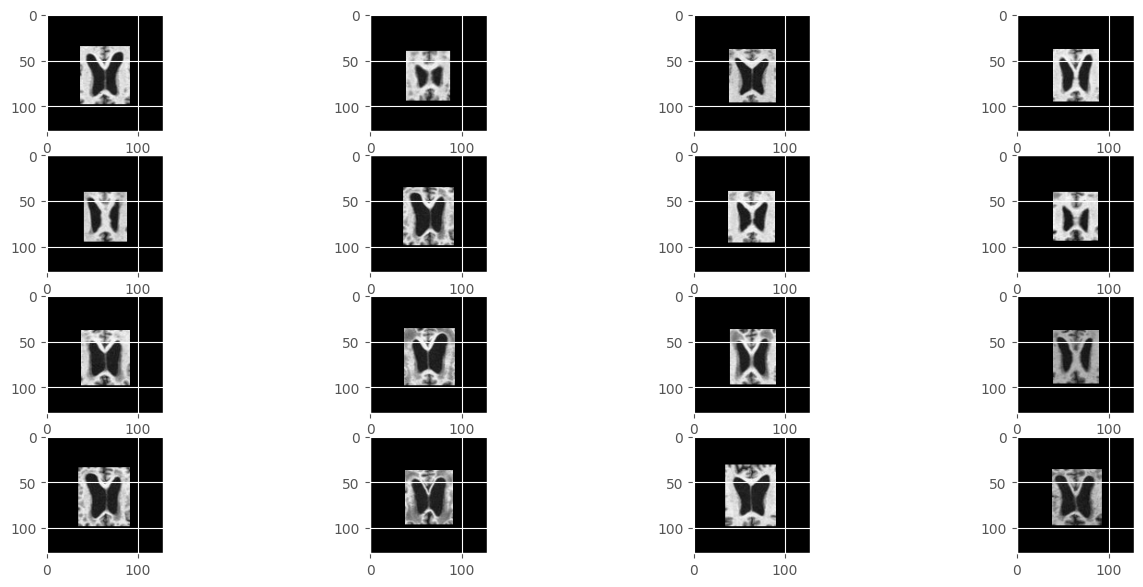

In [ ]:
plot_Xtrain = Xtrain

plt.rcParams['figure.figsize'] = [16,7]

for idx,plot_Xtrain in enumerate(plot_Xtrain):
  plt.subplot(4,4,idx+1)
  plt.imshow(plot_Xtrain)
plt.show()

**Apply CNN model**

In [ ]:
Xtrain, Ytrain = shuffle(Xtrain, Ytrain, random_state=42)

In [ ]:
xtrain,xtest, Ytrain,ytest = train_test_split(Xtrain, Ytrain,test_size=0.1, random_state=42)

In [ ]:
ytrain_new = []
ytest_new = []

for i in Ytrain:
    ytrain_new.append(labels.index(i))#Converting String Label to integer i.e

ytrain = to_categorical(ytrain_new) #Converts a class vector (integers) to binary class matrix

for i in ytest:
    ytest_new.append(labels.index(i))

ytest = to_categorical(ytest_new)

In [ ]:
image_size=128


In [ ]:
efficientnetB4= EfficientNetB4(include_top=False,weights='imagenet',input_shape=(image_size, image_size, 3))

In [ ]:
# Output of model

model = efficientnetB4.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB4.input, outputs=model)

In [ ]:
model.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
filepath = './inception_bboxMask_v3.hdf5'

In [ ]:
tf.keras.callbacks.ModelCheckpoint(
filepath,
monitor = 'val_loss',
verbose = 0,
save_best_only  = False,
save_weights_only = False,
mode = 'auto',
save_freq='epoch',
options=None,
initial_value_threshold=None
 )

In [ ]:
tensorBoard = TensorBoard(log_dir="logs")
checkPoint = ModelCheckpoint("efficientNetB4.h5",
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                             factor=0.3,
                             patience=2,
                             verbose=1,
                             mode='auto',
                            min_delta=0.001)

In [ ]:
history = model.fit(xtrain,
                    ytrain,
                    batch_size=32,
                    validation_split=0.1,
                    epochs=20,
                    verbose=1,
                    callbacks=[tensorBoard, checkPoint, reduce_lr])

pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(ytest, axis=1)
print(classification_report(actual_label, pred))

Epoch 1/20
146/146 [==============================] - ETA: 0s - loss: 1.0162 - accuracy: 0.5181

146/146 [==============================] - 11s 64ms/step - loss: 1.0162 - accuracy: 0.5181 - val_loss: 0.8612 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 2/20
145/146 [============================>.] - ETA: 0s - loss: 0.8576 - accuracy: 0.5987

146/146 [==============================] - 7s 45ms/step - loss: 0.8569 - accuracy: 0.5996 - val_loss: 0.8510 - val_accuracy: 0.6069 - lr: 0.0010
Epoch 3/20
145/146 [============================>.] - ETA: 0s - loss: 0.8042 - accuracy: 0.6235

146/146 [==============================] - 7s 46ms/step - loss: 0.8044 - accuracy: 0.6234 - val_loss: 0.8418 - val_accuracy: 0.5877 - lr: 0.0010
Epoch 4/20
145/146 [============================>.] - ETA: 0s - loss: 0.7661 - accuracy: 0.6381

146/146 [==============================] - 7s 46ms/step - loss: 0.7652 - accuracy: 0.6384 - val_loss: 0.7341 - val_accuracy: 0.6705 - lr: 0.0010
Epoch 5/20
145/146 [============================>.] - ETA: 0s - loss: 0.7003 - accuracy: 0.6750

146/146 [==============================] - 7s 45ms/step - loss: 0.6989 - accuracy: 0.6759 - val_loss: 0.7641 - val_accuracy: 0.6146 - lr: 0.0010
Epoch 6/20
145/146 [============================>.] - ETA: 0s - loss: 0.6566 - accuracy: 0.6901

146/146 [==============================] - 7s 45ms/step - loss: 0.6574 - accuracy: 0.6896 - val_loss: 0.7149 - val_accuracy: 0.6859 - lr: 0.0010
Epoch 7/20
145/146 [============================>.] - ETA: 0s - loss: 0.6307 - accuracy: 0.7043

146/146 [==============================] - 7s 45ms/step - loss: 0.6300 - accuracy: 0.7050 - val_loss: 0.6855 - val_accuracy: 0.6956 - lr: 0.0010
Epoch 8/20
145/146 [============================>.] - ETA: 0s - loss: 0.5816 - accuracy: 0.7414

146/146 [==============================] - 7s 45ms/step - loss: 0.5809 - accuracy: 0.7415 - val_loss: 0.8249 - val_accuracy: 0.6898 - lr: 0.0010
Epoch 9/20
145/146 [============================>.] - ETA: 0s - loss: 0.5894 - accuracy: 0.7453

146/146 [==============================] - 7s 45ms/step - loss: 0.5888 - accuracy: 0.7451 - val_loss: 0.7170 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 10/20
145/146 [============================>.] - ETA: 0s - loss: 0.5086 - accuracy: 0.7778

146/146 [==============================] - 7s 45ms/step - loss: 0.5091 - accuracy: 0.7771 - val_loss: 0.6924 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 11/20
145/146 [============================>.] - ETA: 0s - loss: 0.5286 - accuracy: 0.7595

146/146 [==============================] - 7s 45ms/step - loss: 0.5297 - accuracy: 0.7588 - val_loss: 0.7710 - val_accuracy: 0.6493 - lr: 0.0010
Epoch 12/20
145/146 [============================>.] - ETA: 0s - loss: 0.4824 - accuracy: 0.7927

146/146 [==============================] - 7s 45ms/step - loss: 0.4820 - accuracy: 0.7934 - val_loss: 0.6826 - val_accuracy: 0.7110 - lr: 0.0010
Epoch 13/20
145/146 [============================>.] - ETA: 0s - loss: 0.4755 - accuracy: 0.7918

146/146 [==============================] - 7s 45ms/step - loss: 0.4756 - accuracy: 0.7919 - val_loss: 0.7256 - val_accuracy: 0.6917 - lr: 0.0010
Epoch 14/20
145/146 [============================>.] - ETA: 0s - loss: 0.4222 - accuracy: 0.8108

146/146 [==============================] - 7s 45ms/step - loss: 0.4214 - accuracy: 0.8109 - val_loss: 0.7091 - val_accuracy: 0.7187 - lr: 0.0010
Epoch 15/20
145/146 [============================>.] - ETA: 0s - loss: 0.4422 - accuracy: 0.8058

146/146 [==============================] - 7s 45ms/step - loss: 0.4415 - accuracy: 0.8064 - val_loss: 0.7550 - val_accuracy: 0.6532 - lr: 0.0010
Epoch 16/20
145/146 [============================>.] - ETA: 0s - loss: 0.4121 - accuracy: 0.8209

146/146 [==============================] - 7s 45ms/step - loss: 0.4123 - accuracy: 0.8208 - val_loss: 0.7459 - val_accuracy: 0.6936 - lr: 0.0010
Epoch 17/20
145/146 [============================>.] - ETA: 0s - loss: 0.3679 - accuracy: 0.8438

146/146 [==============================] - 7s 45ms/step - loss: 0.3681 - accuracy: 0.8439 - val_loss: 0.6348 - val_accuracy: 0.7669 - lr: 0.0010
Epoch 18/20
145/146 [============================>.] - ETA: 0s - loss: 0.3655 - accuracy: 0.8472

146/146 [==============================] - 7s 45ms/step - loss: 0.3657 - accuracy: 0.8469 - val_loss: 0.8086 - val_accuracy: 0.6744 - lr: 0.0010
Epoch 19/20
145/146 [============================>.] - ETA: 0s - loss: 0.3616 - accuracy: 0.8483

146/146 [==============================] - 7s 45ms/step - loss: 0.3618 - accuracy: 0.8482 - val_loss: 0.6832 - val_accuracy: 0.7168 - lr: 0.0010
Epoch 20/20
145/146 [============================>.] - ETA: 0s - loss: 0.3118 - accuracy: 0.8707

19/19 [==============================] - 1s 39ms/step
              precision    recall  f1-score   support

           0       0.72      0.75      0.73        81
           1       0.73      1.00      0.84         8
           2       0.72      0.87      0.79       291
           3       0.77      0.50      0.60       197

    accuracy                           0.73       577
   macro avg       0.73      0.78      0.74       577
weighted avg       0.74      0.73      0.72       577



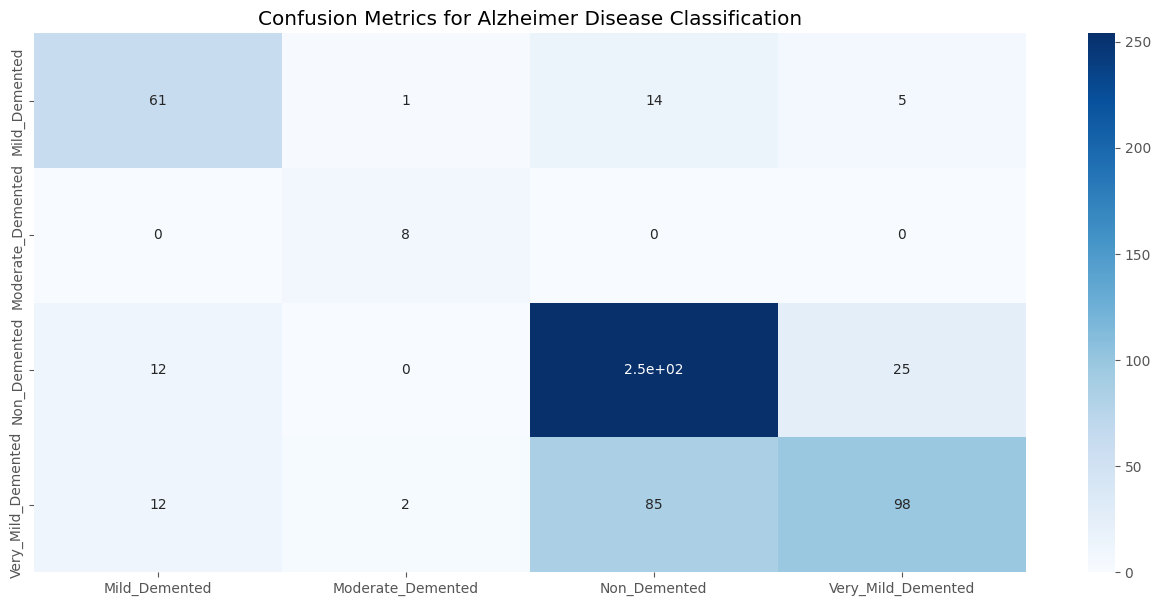

In [ ]:
Cm=confusion_matrix(actual_label,pred)
ax=plt.axes()
sns.heatmap(Cm, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
           yticklabels=labels,
           ax=ax
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification")
plt.show()

In [ ]:
def accuracy_and_loss_Plot(modelData):

    fig=plt.figure(figsize=(10,10))

    plt.subplot(221)
    plt.plot(modelData.history["accuracy"], 'bo--',label='accuracy')
    plt.plot(modelData.history["val_accuracy"],'ro--',label='val_accuracy')
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy Information")
    #plt.grid()
    plt.legend()
    plt.tight_layout()

    plt.subplot(222)
    plt.plot(modelData.history["loss"], 'bo--',label='loss')
    plt.plot(modelData.history["val_loss"],'ro--',label='val_loss')
    plt.title("Training Data Loss Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss Information")
    #plt.grid()
    plt.legend()
    plt.tight_layout()

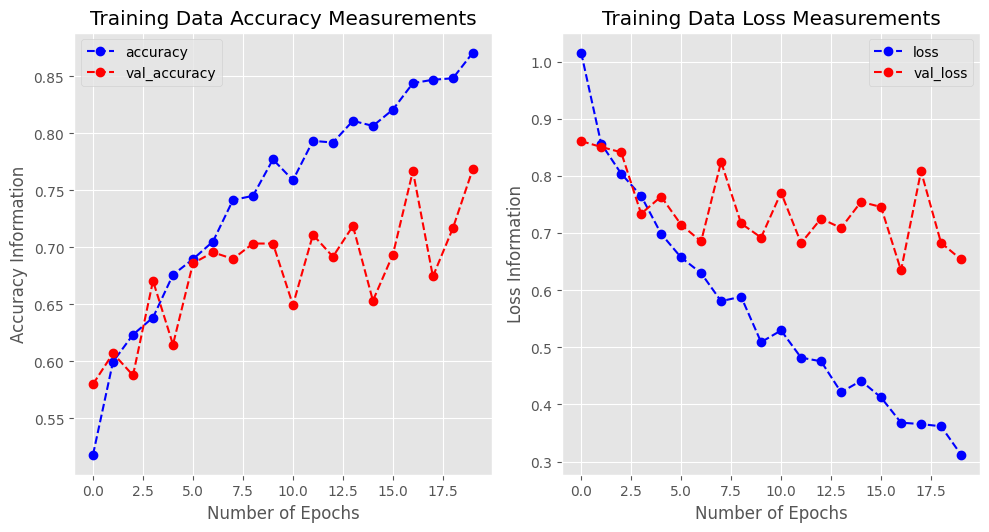

In [ ]:
accuracy_and_loss_Plot(history)